Read data from csv and create a basic Time serie object

In [2]:
library(forecast)
library(car)
library(ggplot2)
#library(zoo)
library(scales)
library(repr)

options(scipen=999)

# Change plot size to 10 x 6
options(repr.plot.width=8, repr.plot.height=5)

jp_data <- read.csv2("japan_employment.csv")
#Remove last row, 2015-01
jp_data <- jp_data[1:nrow(jp_data) - 1,]
jp_data$Date <- as.Date(jp_data$Date, format = "%Y-%m-%d")
#Create column with month value
jp_data$Month <- sapply(jp_data$Date, function(x) {format(as.Date(x), "%m")})
#jp_observed_ts <- zoo(jp_data)

Warning message:
: package 'forecast' was built under R version 3.2.5Loading required package: zoo
Warning message:
: package 'zoo' was built under R version 3.2.5
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: timeDate
Warning message:
: package 'timeDate' was built under R version 3.2.3This is forecast 7.1 

Warning message:
: package 'car' was built under R version 3.2.5Warning message:
: package 'ggplot2' was built under R version 3.2.5Warning message:
: package 'scales' was built under R version 3.2.5

,Date,Value,Month
1,2002-01-01,67.70215,01
2,2002-02-01,67.55654,02
3,2002-03-01,67.91463,03
4,2002-04-01,68.32146,04
5,2002-05-01,68.32711,05
6,2002-06-01,68.58675,06


Display the unmodified time serie

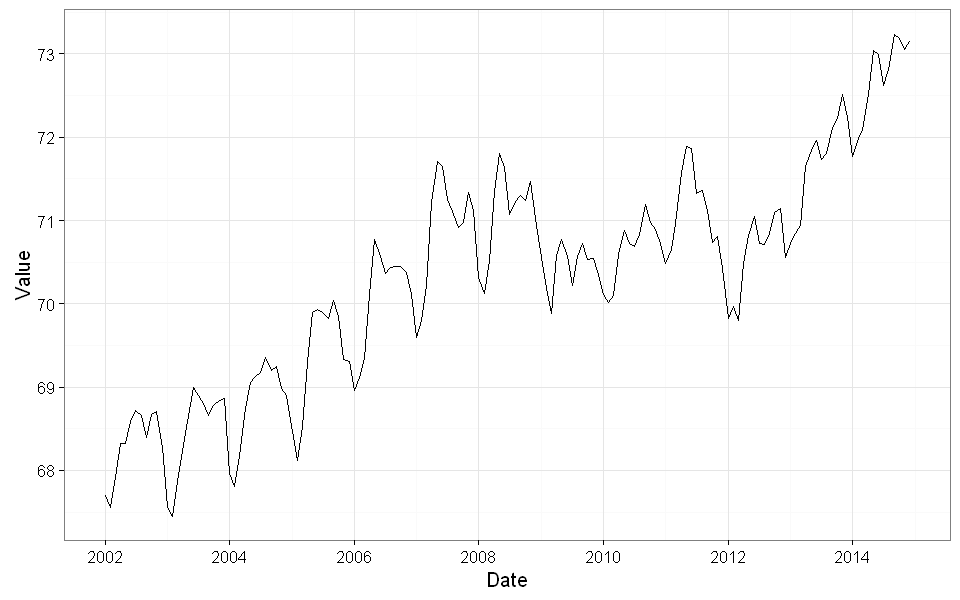

In [638]:
ggplot(jp_data, aes(group = 1)) +
    geom_line(aes(x = Date, y = Value)) +
    theme_bw()

Decompose time serie

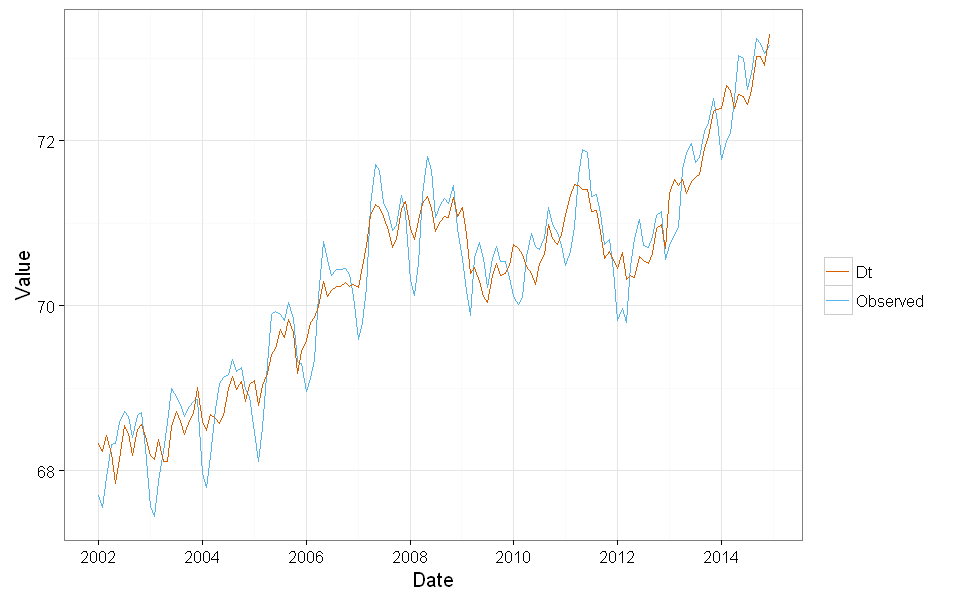

In [639]:
#Calculate moving average
jp_data$Seasonal_Comp <- ma(jp_data$Value, 12)
jp_data$Seasonal_Comp <- ma(jp_data$Seasonal, 4, centre = TRUE)

#Calculate rough seasonal component
jp_data$Seasonal_Comp <- jp_data$Value - jp_data$Seasonal_Comp

temp_monthly_comp <- aggregate(jp_data$Seasonal_Comp ~ jp_data$Month, FUN = mean)
colnames(temp_monthly_comp) <- c("Month", "Seasonal_Comp")

#Calculate how much bigger or smaller the rough component is
fix_ratio <- sum(temp_monthly_comp$Seasonal_Comp) / 12

#Fix the rough seasonal component
temp_monthly_comp$Seasonal_Comp <- temp_monthly_comp$Seasonal_Comp - fix_ratio
jp_data$Seasonal_Comp <- rep(temp_monthly_comp$Seasonal_Comp, 13)

jp_data$Dt <- jp_data$Value - jp_data$Seasonal_Comp

ggplot(jp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Dt, color="Dt")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Dt="#D55E00")) +
    theme_bw()

Analyse trend, Linear model


Call:
lm(formula = jp_data$Dt ~ index(jp_data))

Residuals:
    Min      1Q  Median      3Q     Max 
-1.1725 -0.3541 -0.1038  0.4012  1.2425 

Coefficients:
                 Estimate Std. Error t value            Pr(>|t|)    
(Intercept)    68.3283586  0.0882264  774.47 <0.0000000000000002 ***
index(jp_data)  0.0254643  0.0009749   26.12 <0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5483 on 154 degrees of freedom
Multiple R-squared:  0.8159,	Adjusted R-squared:  0.8147 
F-statistic: 682.3 on 1 and 154 DF,  p-value: < 0.00000000000000022


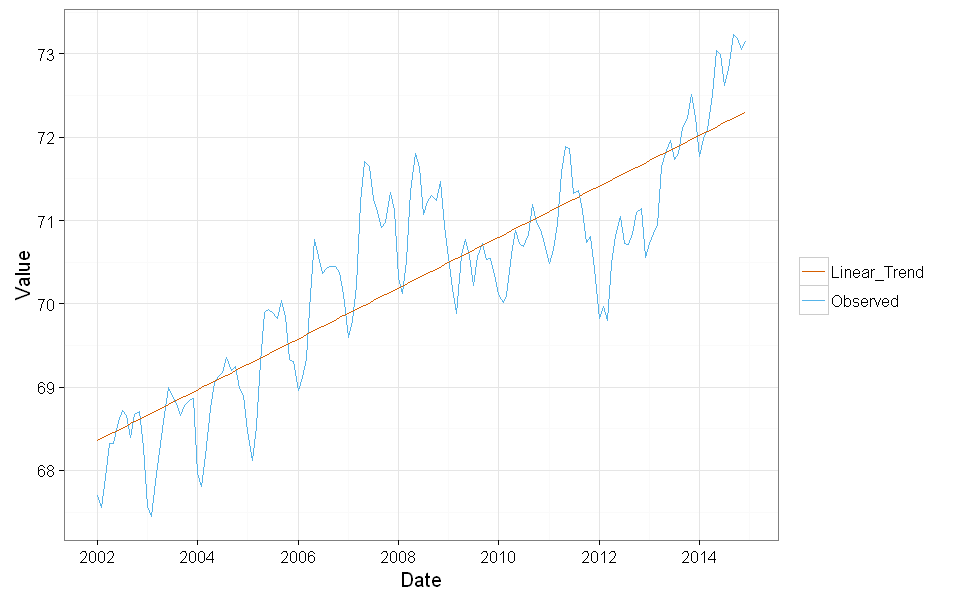

In [640]:
jp_linear_model <- lm(jp_data$Dt ~ index(jp_data))
summary(jp_linear_model)
jp_data$Linear_Fit <- jp_linear_model$fitted


ggplot(jp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Linear_Fit, color="Linear_Trend")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Linear_Trend="#D55E00")) +
    theme_bw()



Analyse trend, Polynomial model


Call:
lm(formula = jp_data$Dt ~ poly(index(jp_data), 3, raw = TRUE))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.91306 -0.34865 -0.02009  0.38773  0.95036 

Coefficients:
                                          Estimate    Std. Error t value
(Intercept)                          67.3396885424  0.1540726047 437.065
poly(index(jp_data), 3, raw = TRUE)1  0.0896149855  0.0084716621  10.578
poly(index(jp_data), 3, raw = TRUE)2 -0.0009191564  0.0001251702  -7.343
poly(index(jp_data), 3, raw = TRUE)3  0.0000036210  0.0000005242   6.908
                                                 Pr(>|t|)    
(Intercept)                          < 0.0000000000000002 ***
poly(index(jp_data), 3, raw = TRUE)1 < 0.0000000000000002 ***
poly(index(jp_data), 3, raw = TRUE)2      0.0000000000118 ***
poly(index(jp_data), 3, raw = TRUE)3      0.0000000001260 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4696 on 152 degrees of freedom
Multiple R

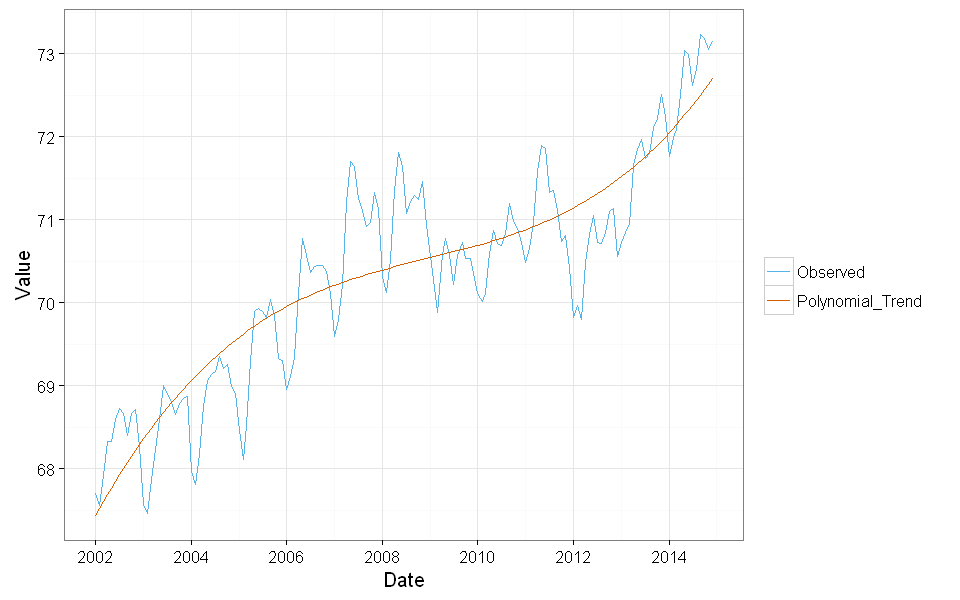

In [641]:
jp_pol_model <- lm(jp_data$Dt ~ poly(index(jp_data), 3, raw = TRUE))
summary(jp_pol_model)
jp_data$Pol_Fit <- jp_pol_model$fitted

ggplot(jp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Pol_Fit, color="Polynomial_Trend")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Polynomial_Trend="#D55E00")) +
    theme_bw()


Analyse trend, exponetial smoothing model


Forecast method: Holt's method

Model Information:
Holt's method 

Call:
 holt(x = jp_data$Dt, h = 12, alpha = 0.9, beta = 0.15, gamma = FALSE) 

  Smoothing parameters:
    alpha = 0.9 
    beta  = 0.15 

  Initial states:
    l = 68.3269 
    b = -0.0055 

  sigma:  0.2152

     AIC     AICc      BIC 
312.4260 312.5045 318.5258 

Error measures:
                      ME      RMSE       MAE         MPE      MAPE     MASE
Training set 0.004820175 0.2151579 0.1762209 0.006587705 0.2509081 1.034591
                   ACF1
Training set 0.03922767

Forecasts:
    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
157       73.37085 73.09511 73.64658 72.94914 73.79255
158       73.47811 73.04739 73.90882 72.81939 74.13683
159       73.58537 73.01609 74.15465 72.71473 74.45600
160       73.69263 72.98896 74.39629 72.61646 74.76879
161       73.79989 72.96195 74.63783 72.51837 75.08140
162       73.90715 72.93325 74.88105 72.41770 75.39660
163       74.01441 72.90194 75.12688 72.31304 75.715

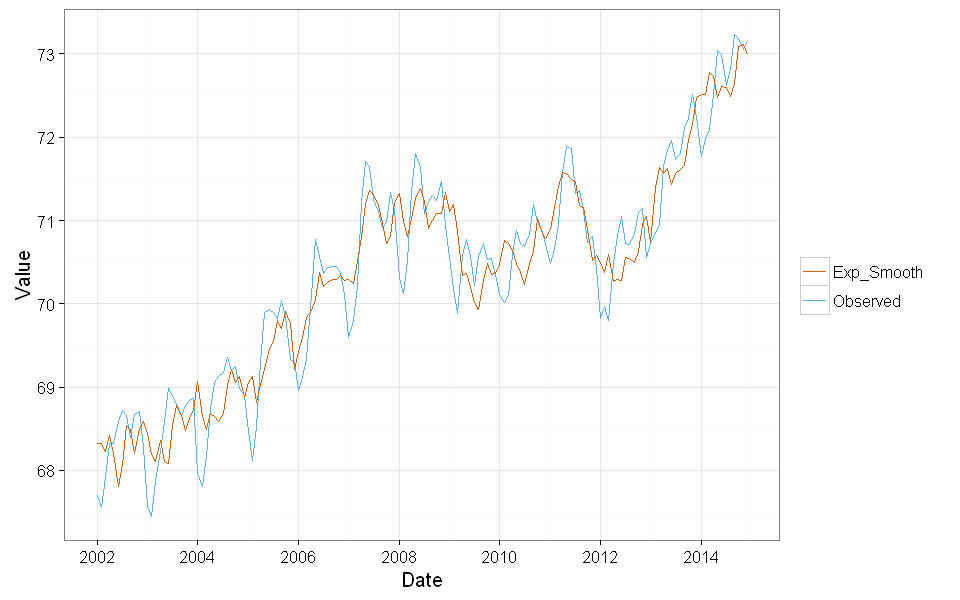

In [642]:
jp_holt_model <- holt(jp_data$Dt, h=12, alpha = 0.90, beta = 0.15, gamma = FALSE)
summary(jp_holt_model)
jp_data$Holt_Fit <- jp_holt_model$fit

ggplot(jp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Holt_Fit, color="Exp_Smooth")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Exp_Smooth="#D55E00")) +
    theme_bw()

Residual Analysis, Pol

[1] 0.1942915

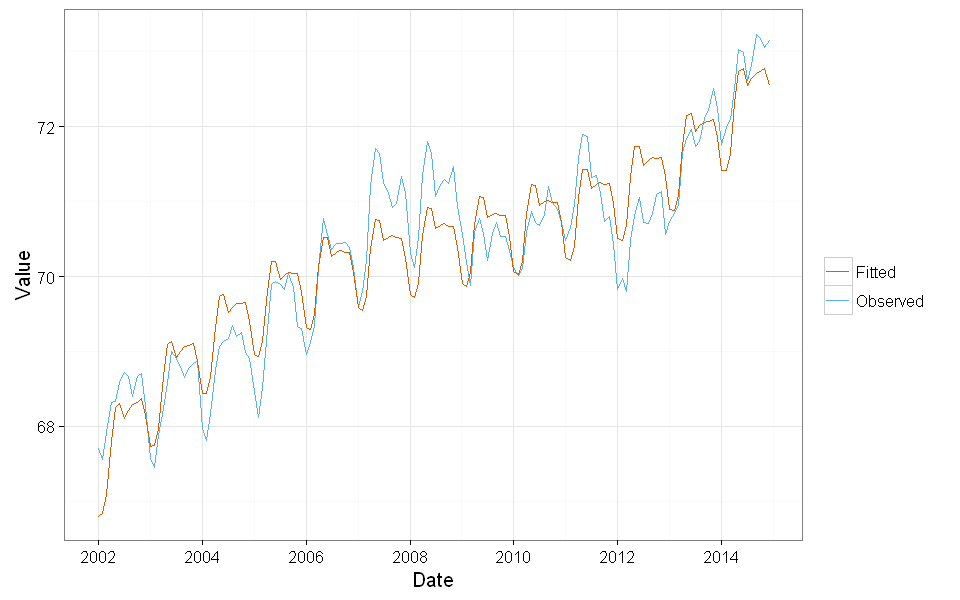

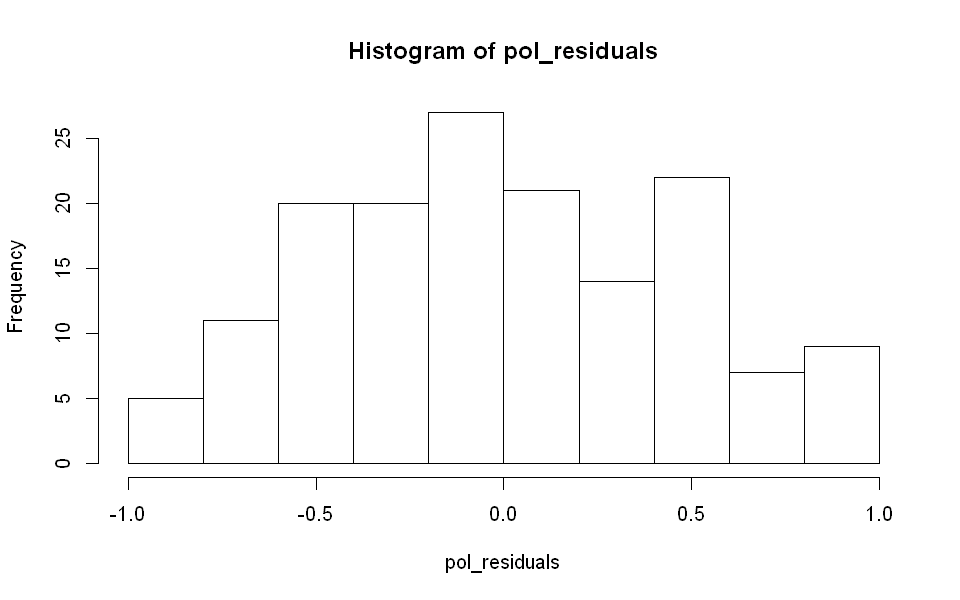

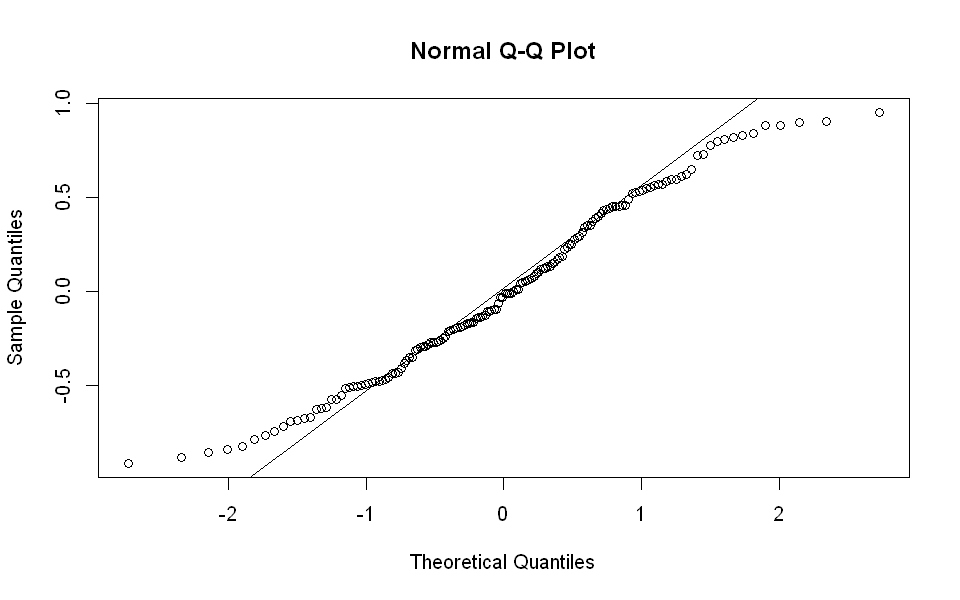

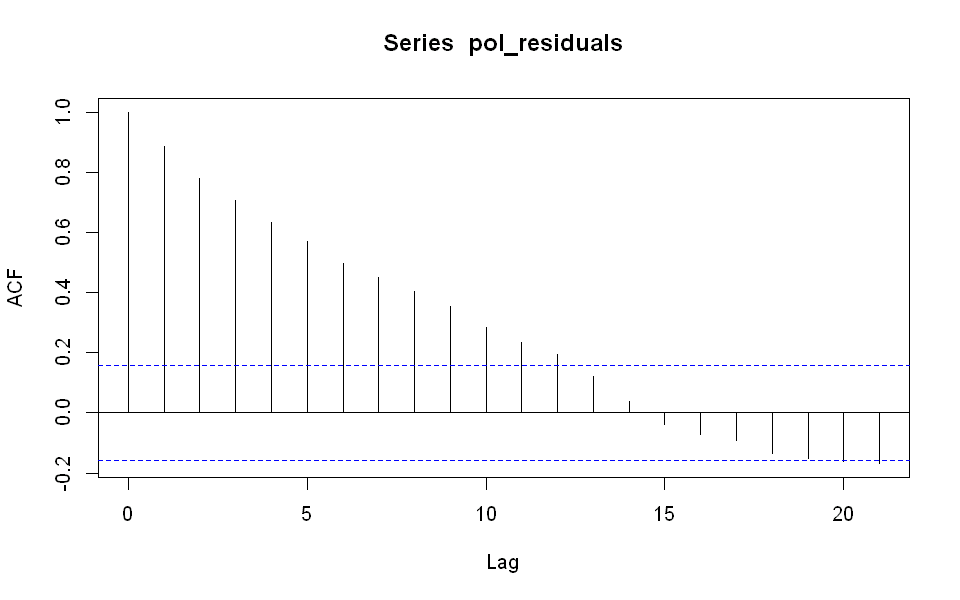

In [643]:
pol_residuals <- jp_data$Value - (jp_data$Pol_Fit + jp_data$Seasonal_Comp)
durbinWatsonTest(pol_residuals)

temp_data <- data.frame(Date = jp_data$Date, Value = jp_data$Value, Fitted = (jp_data$Pol_Fit + jp_data$Seasonal_Comp))
ggplot(temp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Fitted, color="Fitted")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Fitted="#D55E00")) +
    theme_bw()

hist(pol_residuals)
qqnorm(pol_residuals)
qqline(pol_residuals)
acf(pol_residuals)

Residual Analysis, Holt

[1] 1.90832

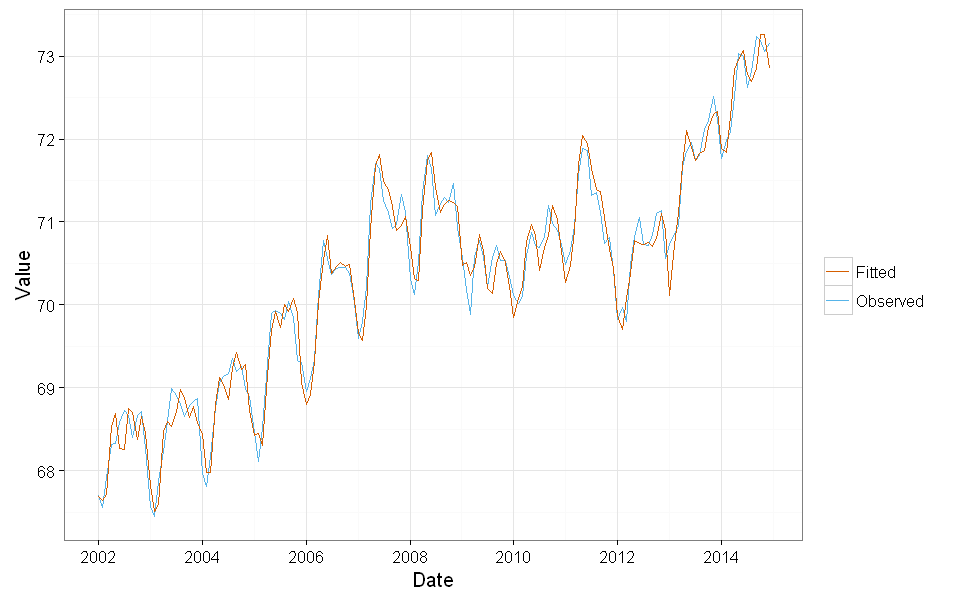

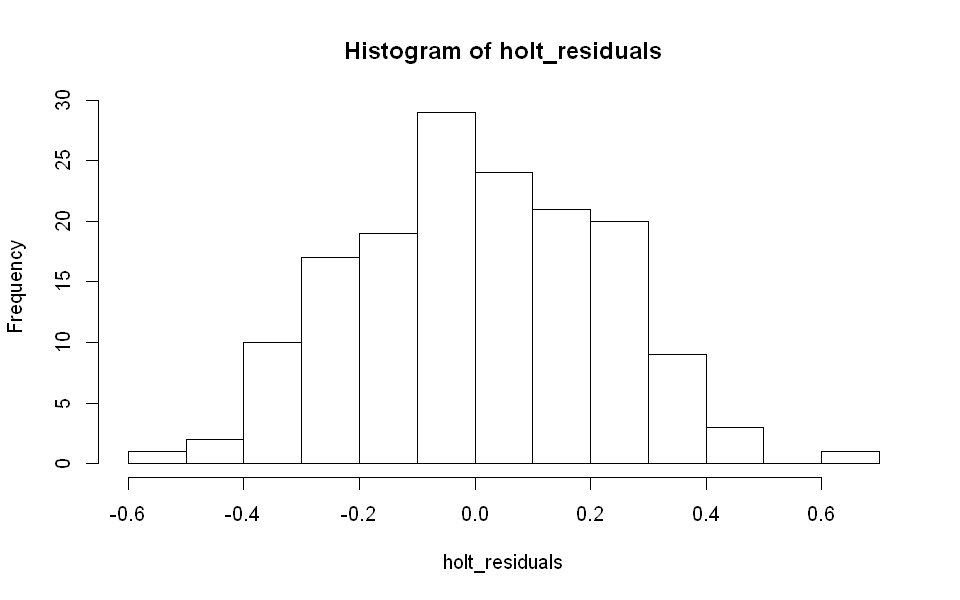

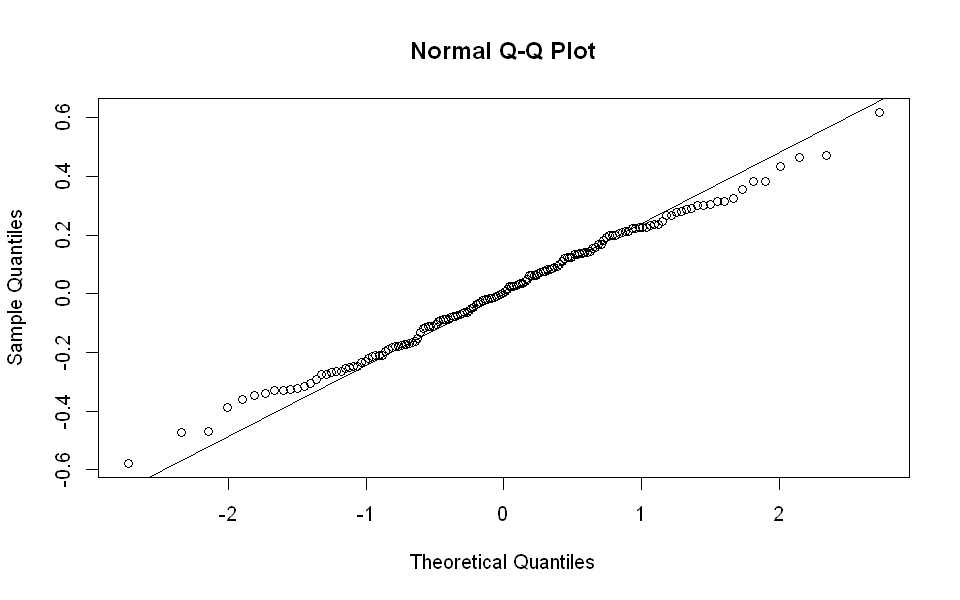

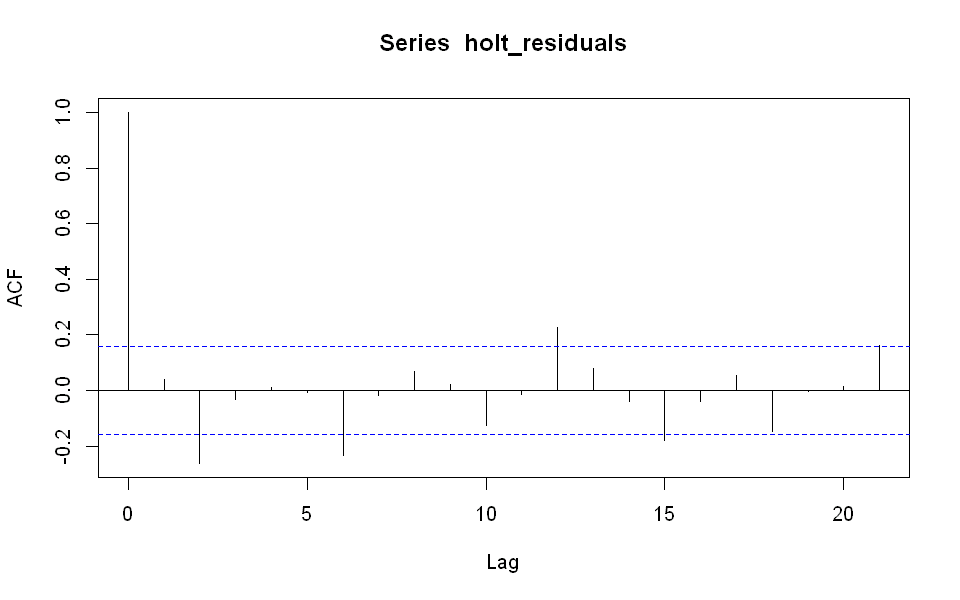

In [644]:
holt_residuals <- jp_data$Value - (jp_data$Holt_Fit + jp_data$Seasonal_Comp)
durbinWatsonTest(as.vector(holt_residuals))

temp_data <- data.frame(Date = jp_data$Date, Value = jp_data$Value, Fitted = (jp_data$Holt_Fit + jp_data$Seasonal_Comp))
ggplot(temp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Fitted, color="Fitted")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Fitted="#D55E00")) +
    theme_bw()

hist(holt_residuals)
qqnorm(holt_residuals)
qqline(holt_residuals)
acf(holt_residuals)

Decompose time serie, cycle

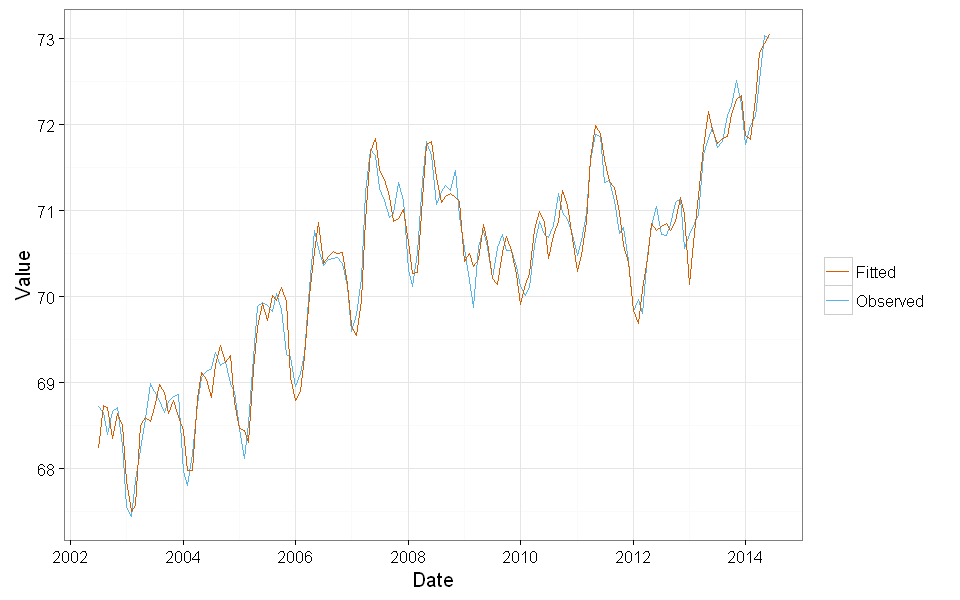

In [645]:
jp_data_shortend <- jp_data
jp_data_shortend$Clir <- jp_data_shortend$Value - (jp_data_shortend$Holt_Fit + jp_data_shortend$Seasonal_Comp)
jp_data_shortend$Cl <- ma(jp_data_shortend$Clir, 13)
jp_data_shortend <- na.omit(jp_data_shortend)
#jp_data_shortend$Ir <- jp_data_shortend$Clir - jp_data_shortend$Cl

#jp_data$Dt <- jp_data$Value - jp_data$Seasonal_Comp

#ggplot(jp_data, aes()) +
#    geom_line(aes(x = Date, y = Value, color="Observed")) +
#    geom_line(aes(x = Date, y = Dt, color="Dt")) +
#    scale_colour_manual(name="", values=c(Observed="#56B4E9", Dt="#D55E00")) +
#    theme_bw()



temp_data <- data.frame(Date = jp_data_shortend$Date,
                        Value = jp_data_shortend$Value,
                        Fitted = (jp_data_shortend$Holt_Fit + 
                                  jp_data_shortend$Seasonal_Comp + 
                                  jp_data_shortend$Cl))
ggplot(temp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Fitted, color="Fitted")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Fitted="#D55E00")) +
    theme_bw()





Forecast method: Holt's method

Model Information:
Holt's method 

Call:
 holt(x = jp_data_shortend$Dt, h = 12, alpha = 0.9, beta = 0.15,  

 Call:
     gamma = FALSE) 

  Smoothing parameters:
    alpha = 0.9 
    beta  = 0.15 

  Initial states:
    l = 68.5565 
    b = -0.0227 

  sigma:  0.2098

     AIC     AICc      BIC 
269.8627 269.9478 275.8023 

Error measures:
                      ME     RMSE       MAE         MPE     MAPE     MASE
Training set 0.003515488 0.209764 0.1703658 0.004929378 0.242536 1.030376
                  ACF1
Training set 0.0496305

Forecasts:
    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
145       72.60291 72.33408 72.87173 72.19178 73.01404
146       72.65619 72.23627 73.07611 72.01398 73.29840
147       72.70947 72.15446 73.26448 71.86066 73.55828
148       72.76275 72.07673 73.44878 71.71357 73.81194
149       72.81604 71.99911 73.63297 71.56665 74.06543
150       72.86932 71.91984 73.81880 71.41721 74.32143
151       72.92260 71.83802 74.007

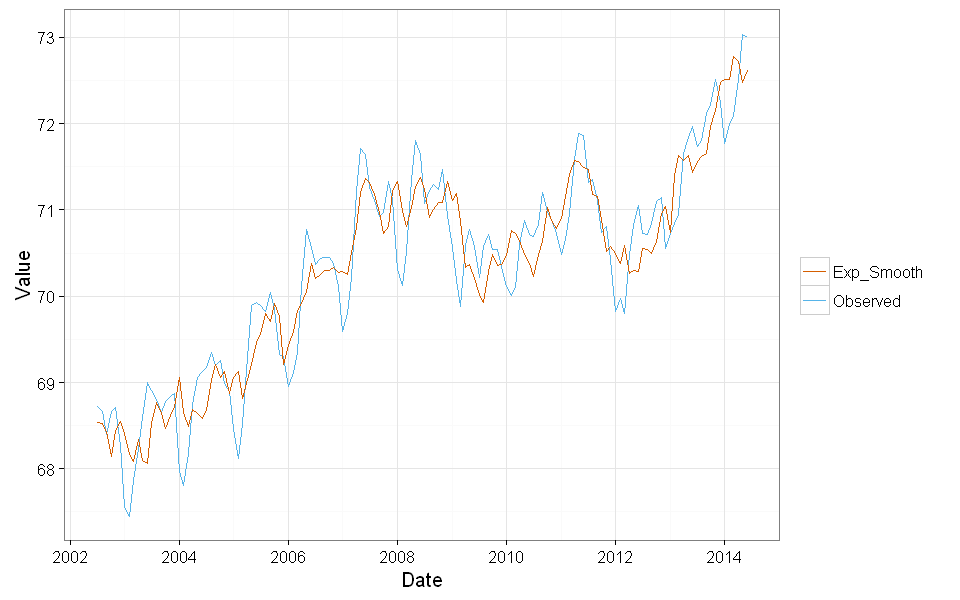

In [646]:
jp_holt_model_short <- holt(jp_data_shortend$Dt, h=12, alpha = 0.90, beta = 0.15, gamma = FALSE)
summary(jp_holt_model_short)
jp_data_shortend$Holt_Fit <- jp_holt_model_short$fit

ggplot(jp_data_shortend, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Holt_Fit, color="Exp_Smooth")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Exp_Smooth="#D55E00")) +
    theme_bw()

[1] 1.941404

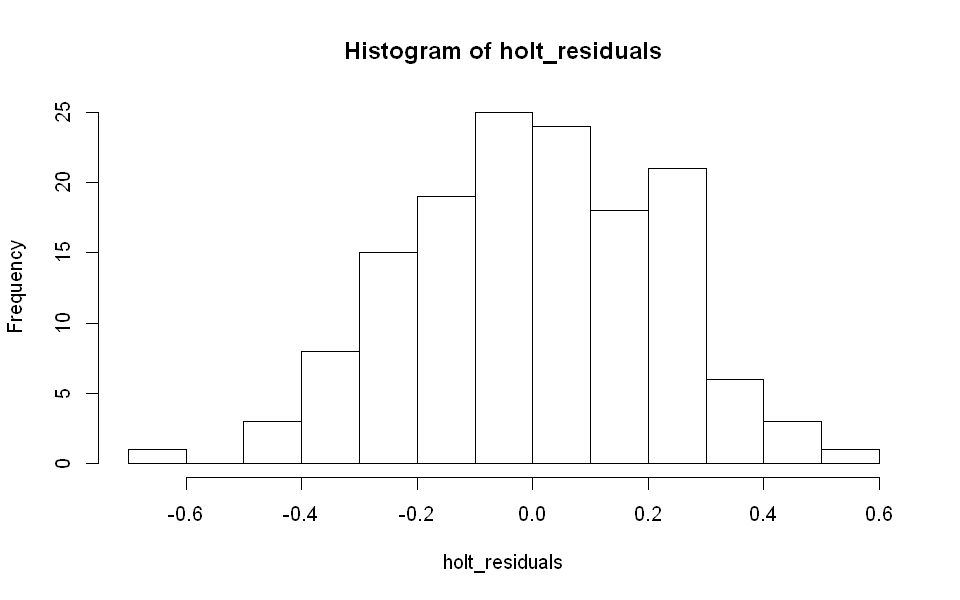

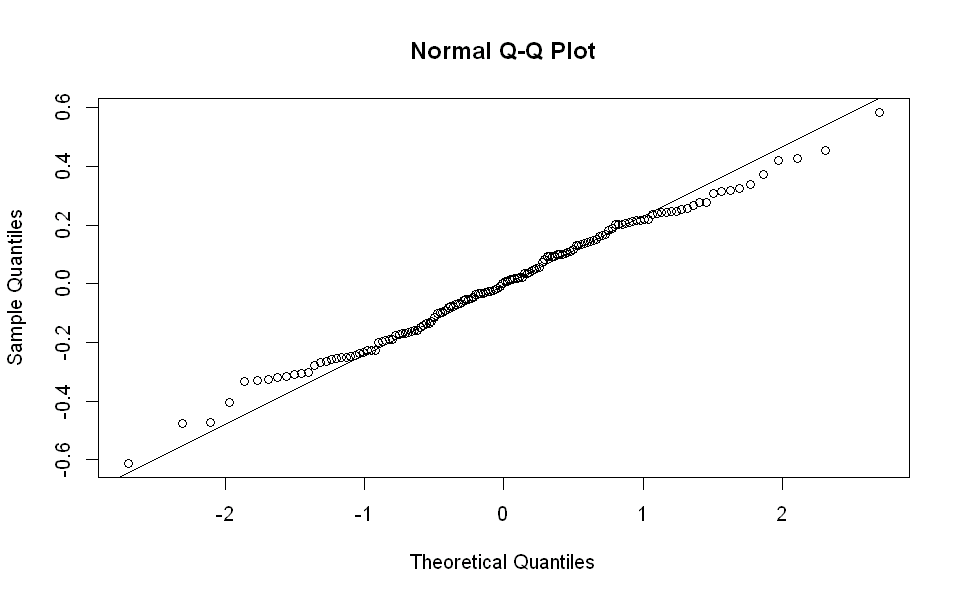

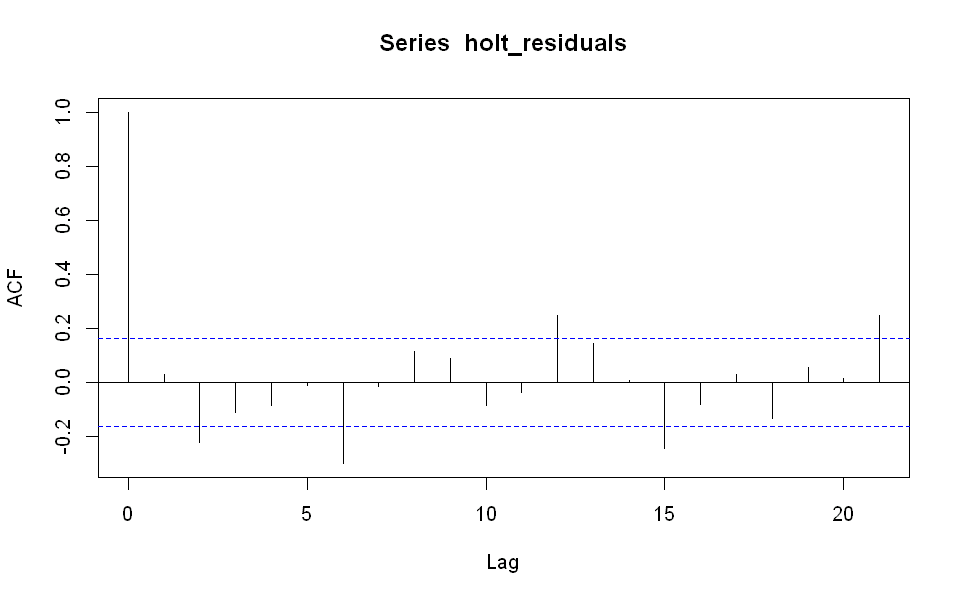

In [647]:
holt_residuals <- jp_data_shortend$Value - (jp_data_shortend$Holt_Fit + 
                                            jp_data_shortend$Seasonal_Comp + 
                                            jp_data_shortend$Cl)
durbinWatsonTest(as.vector(holt_residuals))

hist(holt_residuals)
qqnorm(holt_residuals)
qqline(holt_residuals)
acf(holt_residuals)

Predict

Warning message:
: Removed 12 rows containing missing values (geom_path).

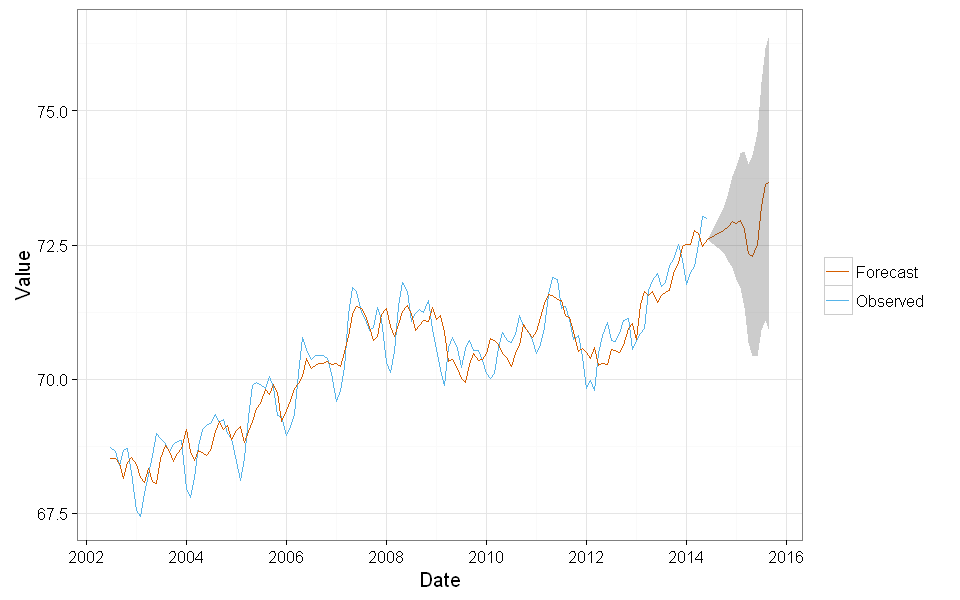

In [648]:
#help(holt)
#jp_holt_model <- holt(jp_data_shortend$Dt , h=24)
#summary(jp_holt_model)

forecast_mean <- jp_holt_model_short$mean + jp_data_shortend$Seasonal_Comp[1:12] + jp_data_shortend$Cl[1:12]
forecast_high <- jp_holt_model_short$lower[,2] + jp_data_shortend$Seasonal_Comp[1:12] + jp_data_shortend$Cl[1:12]
forecast_low <- jp_holt_model_short$upper[,2] + jp_data_shortend$Seasonal_Comp[1:12] + jp_data_shortend$Cl[1:12]

predict_data <- data.frame(Date = c(jp_data_shortend$Date, seq(as.Date("2014-10-01"), by = "month", length.out = 12)),
                        Value = c(jp_data_shortend$Value, rep(NA, 12)),
                        Forecast = c(jp_data_shortend$Holt_Fit, forecast_mean),
                        Forecast_low = c(jp_data_shortend$Holt_Fit, forecast_low),
                        Forecast_high = c(jp_data_shortend$Holt_Fit, forecast_high))
#predict_data

ggplot(predict_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Forecast, color="Forecast")) +
    geom_ribbon(aes(x = Date, ymin=Forecast_low, ymax=Forecast_high), alpha=.25) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Forecast="#D55E00")) +
    theme_bw()


predict without cycle

Warning message:
: Removed 12 rows containing missing values (geom_path).

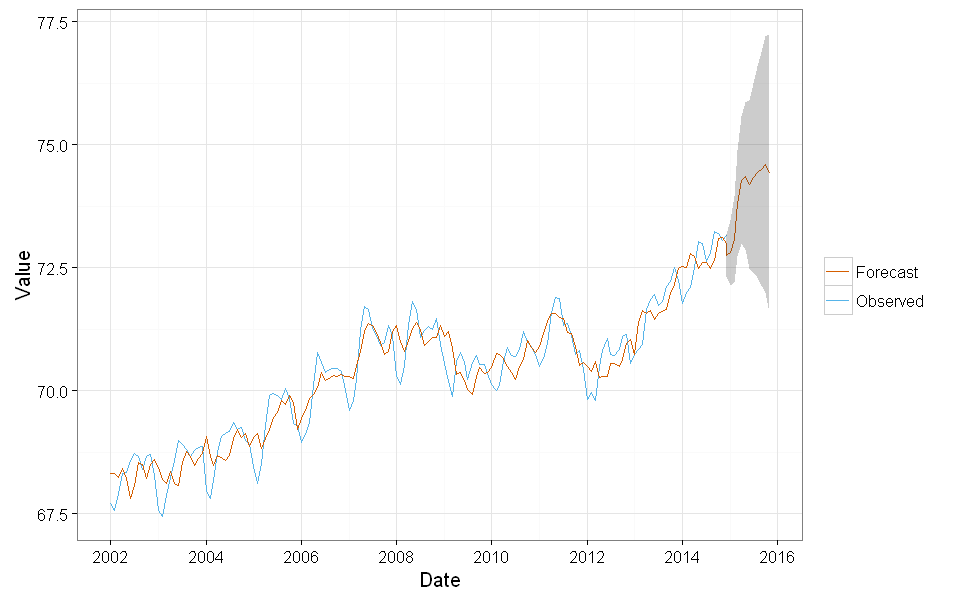

In [649]:
#help(holt)
#jp_holt_model <- holt(jp_data$Dt , h=24)
#summary(jp_holt_model)

forecast_mean <- jp_holt_model$mean + jp_data$Seasonal_Comp[1:12]
forecast_high <- jp_holt_model$lower[,2] + jp_data$Seasonal_Comp[1:12]
forecast_low <- jp_holt_model$upper[,2] + jp_data$Seasonal_Comp[1:12]

predict_data <- data.frame(Date = c(jp_data$Date, seq(as.Date("2014-12-01"), by = "month", length.out = 12)),
                        Value = c(jp_data$Value, rep(NA, 12)),
                        Forecast = c(jp_data$Holt_Fit, forecast_mean),
                        Forecast_low = c(jp_data$Holt_Fit, forecast_low),
                        Forecast_high = c(jp_data$Holt_Fit, forecast_high))
#predict_data

ggplot(predict_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Forecast, color="Forecast")) +
    geom_ribbon(aes(x = Date, ymin=Forecast_low, ymax=Forecast_high), alpha=.25) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Forecast="#D55E00")) +
    theme_bw()